## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [4]:
import os

# 1. Скачиваем архив с данными (если его еще нет)
if not os.path.exists("UCI HAR Dataset.zip"):
    print("Downloading dataset...")
    !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
else:
    print("Dataset archive already exists.")

# 2. Распаковываем архив (если папка еще не создана)
if not os.path.exists("UCI HAR Dataset"):
    print("Unzipping dataset...")
    !unzip -q "UCI HAR Dataset.zip"
    print("Done!")
else:
    print("Dataset already unzipped.")

--2025-12-14 09:21:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [    <=>             ]  58.17M  78.3MB/s    in 0.7s    

2025-12-14 09:21:09 (78.3 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Unzipping dataset...
Done!


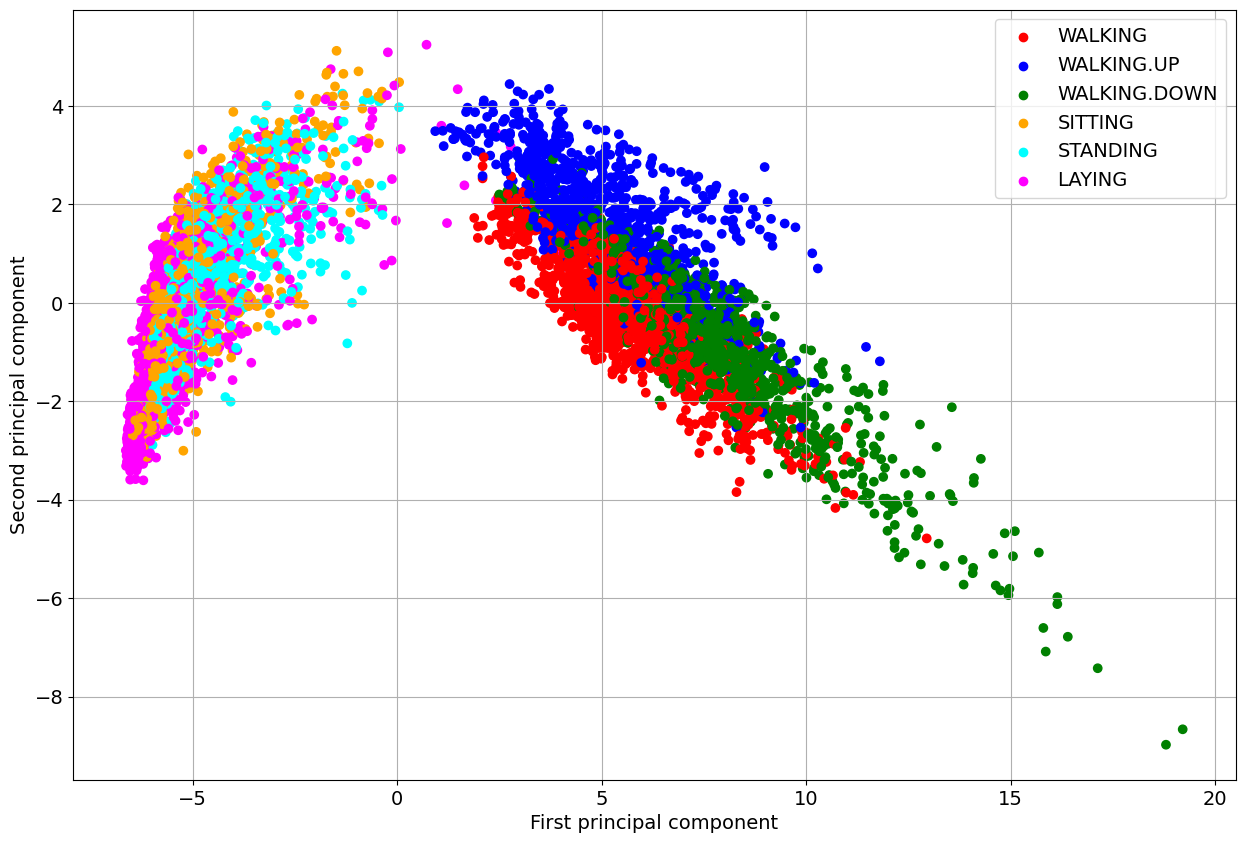

In [5]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [6]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [7]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [8]:
# Your experiments here
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


# меняем размерность с (N, 128, 9) на (N, 9, 128), так как Conv1d любит каналы первыми
X_train_tensor = torch.tensor(X_train).float().permute(0, 2, 1)
# Добавляем .view(-1)
y_train_tensor = torch.tensor(y_train).long().view(-1)

X_test_tensor = torch.tensor(X_test).float().permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test).long().view(-1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Shape of batch: {next(iter(train_loader))[0].shape}")


Shape of batch: torch.Size([64, 9, 128])


In [9]:
class HAR_CNN(nn.Module):
    def __init__(self, n_channels=9, n_classes=6):
        super(HAR_CNN, self).__init__()

        # Блок 1: Низкоуровневые признаки
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            # Блок 2: Среднеуровневые признаки
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            # Блок 3: Высокоуровневые признаки
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            # AdaptiveAvgPool1d(1)
            nn.AdaptiveAvgPool1d(1)
        )

        # Классификатор
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        features = self.net(x)
        features = features.squeeze(2)
        out = self.fc(features)
        return out

model = HAR_CNN().to(device)
print(model)

HAR_CNN(
  (net): Sequential(
    (0): Conv1d(9, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): AdaptiveAvgPool1d(output_size=1)
  )
  (fc): Linear(in_features=256, out_features=6, bias=True)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    test_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {epoch_acc:.2f}%")

print(f"Final Accuracy: {test_accuracies[-1]:.2f}%")

Epoch [1/30], Loss: 0.3618, Test Accuracy: 91.45%
Epoch [2/30], Loss: 0.1365, Test Accuracy: 89.51%
Epoch [3/30], Loss: 0.1242, Test Accuracy: 92.23%
Epoch [4/30], Loss: 0.1171, Test Accuracy: 92.33%
Epoch [5/30], Loss: 0.1103, Test Accuracy: 92.47%
Epoch [6/30], Loss: 0.1121, Test Accuracy: 92.40%
Epoch [7/30], Loss: 0.1094, Test Accuracy: 93.55%
Epoch [8/30], Loss: 0.1043, Test Accuracy: 92.23%
Epoch [9/30], Loss: 0.1024, Test Accuracy: 91.28%
Epoch [10/30], Loss: 0.1052, Test Accuracy: 93.82%
Epoch [11/30], Loss: 0.0984, Test Accuracy: 92.98%
Epoch [12/30], Loss: 0.0981, Test Accuracy: 93.38%
Epoch [13/30], Loss: 0.0981, Test Accuracy: 93.01%
Epoch [14/30], Loss: 0.0941, Test Accuracy: 92.91%
Epoch [15/30], Loss: 0.0918, Test Accuracy: 92.33%
Epoch [16/30], Loss: 0.0884, Test Accuracy: 91.18%
Epoch [17/30], Loss: 0.0935, Test Accuracy: 92.53%
Epoch [18/30], Loss: 0.0934, Test Accuracy: 93.59%
Epoch [19/30], Loss: 0.0872, Test Accuracy: 93.25%
Epoch [20/30], Loss: 0.0845, Test Accura

Я делал через **одномерную сверточную сеть (1D-CNN)**.
Идея в том, что структура данных с гироскопа и акселерометра (которые работают на определение положения и движения устройства в пространстве) имеют дело с резкими пиками и колебаниями, с которыми сверточные сети работают лучше, чем рекуррентные.

**Детали :**
1.  **Предобработка:** . Conv1d в PyTorch ожидает данные в формате (Batch, Channels, Time), поэтому пришлось поменять местами оси каналов и времени.
2.  **Архитектура** --  3-слойная сверточная сеть:
  Количество фильтров увеличивается с глубиной: **64 $\to$ 128 $\to$ 256**, что позволяет выделять всё более абстрактные признаки.
    *   Как и в прошлых задания использовал **Batch Normalization** (после каждой свертки для ускорения сходимости) и **Dropout (p=0.3)** (для предотвращения переобучения на шумных сигналах).
    *   Финальный слой — Global Average Pooling (AdaptiveAvgPool1d), который усредняет признаки по временной оси. Он сжимает весь временной сигнал в один усреднённый вектор, благодаря чему модель становится проще и легче.

## В итоге точность 93.76% на тестовой выборке.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

*   **Модель:** `ResNet50` (предобученная на ImageNet) с заменой последнего полносвязного слоя.
*   **Гиперпараметры:** Adam, LR=1e-4.
*   **Результат:** Точность на валидации достигала **~90.7%** в лучшем случае.

###  **#** закомментировал код


In [16]:
import torch.optim as optim
from torchvision import models
import torch.nn as nn
from tqdm import tqdm

model_resnet = models.resnet50(weights='IMAGENET1K_V1')

num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 50)
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=1e-4)


num_epochs_resnet = 10

# for epoch in range(num_epochs_resnet):
#     model_resnet.train()
#     running_loss = 0.0
#
#     for inputs, labels in tqdm(train_loader, desc=f"ResNet Epoch {epoch+1}"):
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer_resnet.zero_grad()
#         outputs = model_resnet(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer_resnet.step()
#         running_loss += loss.item()
#
#     # Validation
#     model_resnet.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model_resnet(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#
#     print(f"ResNet Epoch {epoch+1} Val Acc: {100 * correct / total:.2f}%")

# **Вариант 2: EfficientNetV2-S**

In [5]:
import random
import numpy as np
import torch
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [6]:
# Your experiments here
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


if not os.path.exists('data.zip'):
    print("Downloading data...")
    !wget -O data.zip "https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=1"
    print("Unzipping...")
    !unzip -q data.zip
    print("Done!")
else:
    print("Data already exists.")

--2025-12-14 10:24:56--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/v4mlweruozv8dbf4fx2xi/data.zip?rlkey=xke12fmqcui4malrwoqveqaai&dl=1 [following]
--2025-12-14 10:24:56--  https://www.dropbox.com/scl/fi/v4mlweruozv8dbf4fx2xi/data.zip?rlkey=xke12fmqcui4malrwoqveqaai&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0a46fb43ea14b38e0880d52844.dl.dropboxusercontent.com/cd/0/inline/C3C2hajg1VtidZdbU8U6H9UVr_CoeXfCBiPP8GIUgIVUuFMU8dhLmtXiSWUUE9AeP5Jf-GBkR4nIin5Z7hF-978AywB7HO95ZxOuQ3WWQvXOwFJTBWIJea8JsTJKne9OuLw/file?dl=1# [following]
--2025-12-14 10:24:57--  https://uc0a46fb43ea14b38e0880d52844.dl.dropboxusercontent.com/cd/0/inline/C3C2hajg1Vt

In [7]:
# 2. Трансформации (Нормализация под ImageNet)
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),       # Аугментация
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = torchvision.datasets.ImageFolder('data/train', transform=train_transforms)

# Разбиваем train/val (80% / 20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print(f"Classes: {len(class_names)}")

Classes: 50


In [10]:
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import torch.nn as nn
import copy

# Модель: EfficientNet V2 Small
print("Загружаем EfficientNet_V2_S...")
model = models.efficientnet_v2_s(weights='DEFAULT')

#  Linear слой (он идет под индексом 1)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

# обучение
num_epochs = 12
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Train Loop
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=running_loss/len(train_loader))

    # Validation Loop
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    scheduler.step(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} Result: Val Accuracy: {val_acc:.2f}% (Best: {best_acc:.2f}%) | LR: {current_lr}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

print(f"\nФинал! Лучшая точность: {best_acc:.2f}%")
model.load_state_dict(best_model_wts)

Загружаем EfficientNet_V2_S...
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 149MB/s]
Epoch 1/12 [Train]: 100%|██████████| 180/180 [01:27<00:00,  2.07it/s, loss=1.61]


Epoch 1 Result: Val Accuracy: 90.31% (Best: 0.00%) | LR: 0.0001


Epoch 2/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.07it/s, loss=0.349]


Epoch 2 Result: Val Accuracy: 92.54% (Best: 90.31%) | LR: 0.0001


Epoch 3/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.07it/s, loss=0.193]


Epoch 3 Result: Val Accuracy: 92.12% (Best: 92.54%) | LR: 0.0001


Epoch 4/12 [Train]: 100%|██████████| 180/180 [01:27<00:00,  2.06it/s, loss=0.144]


Epoch 4 Result: Val Accuracy: 91.49% (Best: 92.54%) | LR: 0.0001


Epoch 5/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.07it/s, loss=0.119]


Epoch 5 Result: Val Accuracy: 92.19% (Best: 92.54%) | LR: 1e-05


Epoch 6/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.07it/s, loss=0.0789]


Epoch 6 Result: Val Accuracy: 93.17% (Best: 92.54%) | LR: 1e-05


Epoch 7/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.08it/s, loss=0.0665]


Epoch 7 Result: Val Accuracy: 92.96% (Best: 93.17%) | LR: 1e-05


Epoch 8/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.09it/s, loss=0.0516]


Epoch 8 Result: Val Accuracy: 92.82% (Best: 93.17%) | LR: 1e-05


Epoch 9/12 [Train]: 100%|██████████| 180/180 [01:25<00:00,  2.10it/s, loss=0.0445]


Epoch 9 Result: Val Accuracy: 92.82% (Best: 93.17%) | LR: 1.0000000000000002e-06


Epoch 10/12 [Train]: 100%|██████████| 180/180 [01:26<00:00,  2.09it/s, loss=0.0418]


Epoch 10 Result: Val Accuracy: 92.89% (Best: 93.17%) | LR: 1.0000000000000002e-06


Epoch 11/12 [Train]: 100%|██████████| 180/180 [01:25<00:00,  2.10it/s, loss=0.043]


Epoch 11 Result: Val Accuracy: 93.24% (Best: 93.17%) | LR: 1.0000000000000002e-06


Epoch 12/12 [Train]: 100%|██████████| 180/180 [01:25<00:00,  2.10it/s, loss=0.0353]


Epoch 12 Result: Val Accuracy: 93.31% (Best: 93.24%) | LR: 1.0000000000000002e-06

Финал! Лучшая точность: 93.31%


<All keys matched successfully>

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

# Класс для тестового датасета
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name


test_dataset_submission = TestDataset('data/test', transform=val_transforms)
test_loader_submission = DataLoader(test_dataset_submission, batch_size=32, shuffle=False)

predictions = []
image_names = []

model.eval()
print(f"Генерация предсказаний для {len(test_dataset_submission)} изображений...")

with torch.no_grad():
    for inputs, names in tqdm(test_loader_submission, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Конвертируем индексы обратно в названия пород
        predicted_labels = [class_names[p] for p in predicted.cpu().numpy()]

        predictions.extend(predicted_labels)
        image_names.extend(names)

# Сохраняем CSV
submission_df = pd.DataFrame({'id': image_names, 'label': predictions})
submission_df.to_csv('submission.csv', index=False, header=False)


Генерация предсказаний для 1503 изображений...


Predicting: 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


### **Ход экспериментов:**
1.  **ResNet50:** Сначала брал **ResNet50**. Запуск с `LR=1e-4` дал  **~90.7%** точности.
2.  **(EfficientNetV2-S):** Чтобы преодолеть порог в 93%, я заменил архитектуру на **EfficientNetV2-S**. Данная модель более современной и считается эффективной для задач Fine-Grained классификации.

**Используемые техники:**
*   **Оптимизация:** Использовал оптимизатор **Adam** с начальным `lr=1e-4`.
*   **Регуляризация:** Добавил **Weight Decay ($1e-3$)**.
*   **Learning Rate Schedule:** планировщик `ReduceLROnPlateau` уменьшал шаг обучения в 10 раз при выходе метрики на плато.


**В итоге** EfficientNetV2-S плюс подстройка гиперпараметров дали лучшей точности -- 93.31% на валидационной выборке.